In [1]:
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
import h5py
from sklearn.cluster import KMeans
from matplotlib import cm
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, MaxAbsScaler, QuantileTransformer, RobustScaler, PowerTransformer
from matplotlib.lines import Line2D
import matplotlib.colors as colors

In [2]:
# read in data 
pathData_train = '/pfs/data5/home/kit/lti/rk3078/JupyterNotebooks/data/singleDF_Train.h5'
db_train = pd.read_hdf(pathData_train, 'df')
pathData_test = '/pfs/data5/home/kit/lti/rk3078/JupyterNotebooks/data/singleDF_Test.h5'
db_test = pd.read_hdf(pathData_test, 'df')

In [3]:
# define plotting parameters
fontSizeSetLarge = 18
fontSizeSetMedium = 14
pceLims = (5,17.5)
vocLims = (0.9,1.15)
jscLims = (16,22)
ffLims = (40,75)

# Baseline for test set - always predicting mean of complete train set

In [4]:
print("Predicting always mean of complete train set for the test set:")
sumError = [0,0,0,0]
for element in range(len(db_test["pce_backward"])):
    sumError[0] += np.abs(np.array(db_test["pce_backward"])[element]-np.mean(db_train["pce_backward"]))
    sumError[1] += np.abs(np.array(db_test["voc_backward"])[element]-np.mean(db_train["voc_backward"]))
    sumError[2] += np.abs(np.array(db_test["jsc_backward"])[element]-np.mean(db_train["jsc_backward"]))
    sumError[3] += np.abs(np.array(db_test["ff_backward"])[element]-np.mean(db_train["ff_backward"]))
    
baselineTestSet=[np.round((sumError[0]/len(db_test["pce_backward"])),3),
                np.round((sumError[1]/len(db_test["voc_backward"])),3),
                np.round((sumError[2]/len(db_test["jsc_backward"])),3),
                np.round((sumError[3]/len(db_test["ff_backward"])),3)]
print("mae PCE: " + str(baselineTestSet[0]))
print("mae VOC: " + str(baselineTestSet[1]))
print("mae JSC: " + str(baselineTestSet[2]))
print("mae FF: " + str(baselineTestSet[3]))

Predicting always mean of complete train set for the test set:
mae PCE: 1.909
mae VOC: 0.034
mae JSC: 1.293
mae FF: 6.412


# MAE dependency on number of clusters for clustering the entire transients

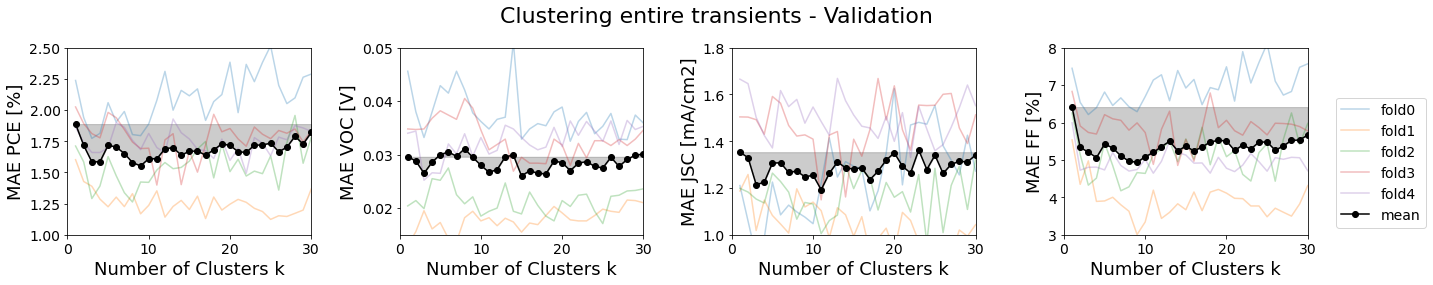

In [5]:
noOfFolds = 5
ks = []
maeList_valid_train = [[],[],[],[],[]]
for k in range(1,31):
    ks.append(k)
    
    # iterate through all folds
    for foldNumber in range(noOfFolds):
        # assign one subset to validation set and the rest to training set
        trainset = db_train[db_train["foldNo"] != foldNumber].copy()
        validset = db_train[db_train["foldNo"] == foldNumber].copy()
        
        # generate a kmeans model
        currentTrainData = pd.DataFrame(data = np.vstack(trainset["LP725"].to_numpy()))
        X = currentTrainData.values.copy()
        kmeans = KMeans(n_clusters = k, random_state = 0)
        cluster_found = kmeans.fit_predict(X)
        currentTrainClusters = currentTrainData.set_index(pd.Series(cluster_found, name = 'cluster'), append = True )
        clusters = sorted(currentTrainClusters.index.get_level_values('cluster').unique())
        
        # generate a nested list with the PV parameters (pce,voc,jsc,ff) for the 4 generated clusters
        listPCE,listVOC,listJSC,listFF = [],[],[],[]
        for cluster in clusters:
            clusterDF = currentTrainClusters.xs(cluster, level = 1)
            listPCE.append(trainset.iloc[clusterDF.index]["pce_backward"])
            listVOC.append(trainset.iloc[clusterDF.index]["voc_backward"])
            listJSC.append(trainset.iloc[clusterDF.index]["jsc_backward"])
            listFF.append(trainset.iloc[clusterDF.index]["ff_backward"])
        pvParams = [listPCE,listVOC,listJSC,listFF]
        
        # compute mean of the 4 PV parameters for the clusters
        cluster_means = []
        for j in range(4):
            currentParam = []
            for i in range(k):
                currentParam.append(pvParams[j][i].mean())
            cluster_means.append(currentParam)
             
        # assign validation data to the generated clusters
        currentValidData = pd.DataFrame(data = np.vstack(validset["LP725"].to_numpy()))
        X2 = currentValidData.values.copy()
        cluster_found2 = kmeans.predict(X2)
        currentValidCluster = currentValidData.set_index(pd.Series(cluster_found2, name = 'cluster'), append = True )
        clusters2 = sorted(currentValidCluster.index.get_level_values('cluster').unique())
        
        # generate a nested list with the PV parameters (pce,voc,jsc,ff) of the validation data for the 4 generated clusters
        listPCE_valid,listVOC_valid,listJSC_valid,listFF_valid = [],[],[],[]
        for cluster in clusters2:
            clusterDF2 = currentValidCluster.xs(cluster, level = 1)
            listPCE_valid.append(validset.iloc[clusterDF2.index]["pce_backward"])
            listVOC_valid.append(validset.iloc[clusterDF2.index]["voc_backward"])
            listJSC_valid.append(validset.iloc[clusterDF2.index]["jsc_backward"])
            listFF_valid.append(validset.iloc[clusterDF2.index]["ff_backward"])
        pvParams_valid = [listPCE_valid,listVOC_valid,listJSC_valid,listFF_valid]
        
        # compute mean absolute error (mae) 
        sumMAEClustersList_valid_train = []
        for j in range(4):
            currentParam = []
            for ix,ab in enumerate(clusters2):
                currentMeanTrain = cluster_means[j][ab]
                currentCluster = pvParams_valid[j][ix]
                sumMAE = 0
                for ac in range(len(currentCluster)):
                    sumMAE += np.abs(np.array(currentCluster)[ac]-currentMeanTrain)
                currentParam.append(sumMAE/(ac+1))
            sumMAEClustersList_valid_train.append(currentParam)
        mae_valid_train = [] 
        for j in range(4):
            mae_valid_train.append(np.round(sum(sumMAEClustersList_valid_train[j])/len(sumMAEClustersList_valid_train[j]),4))     # MAE mean taken from 4 clusters of current fold
        maeList_valid_train[foldNumber].append(mae_valid_train)


meanPCEdiffKs,meanVOCdiffKs,meanJSCdiffKs,meanFFdiffKs = [],[],[],[]
for x in range(len(ks)):
    meanPCEdiffKs.append(np.round(np.mean(np.array(maeList_valid_train)[:,x,0]),4))
    meanVOCdiffKs.append(np.round(np.mean(np.array(maeList_valid_train)[:,x,1]),4))
    meanJSCdiffKs.append(np.round(np.mean(np.array(maeList_valid_train)[:,x,2]),4))
    meanFFdiffKs.append(np.round(np.mean(np.array(maeList_valid_train)[:,x,3]),4))

# use mae computed using k=1 as baseline 
baselineValidation=[np.round(meanPCEdiffKs[0],3),np.round(meanVOCdiffKs[0],3),np.round(meanJSCdiffKs[0],3),np.round(meanFFdiffKs[0],3)]

fig,ax = plt.subplots(1,4, figsize = (20,4))
for foldNo in range(5):
    for paramNo in range(4):
        ax[paramNo].plot(ks,np.array(maeList_valid_train)[foldNo,:,paramNo], alpha = 0.3,label = "fold"+str(foldNo))      
ax[0].plot(ks,meanPCEdiffKs,"k-o",label = "mean")
ax[0].fill_between(ks, meanPCEdiffKs, meanPCEdiffKs[0], color = 'k', alpha = 0.2)
ax[1].plot(ks,meanVOCdiffKs,"k-o",label = "mean")
ax[1].fill_between(ks, meanVOCdiffKs, meanVOCdiffKs[0], color = 'k', alpha = 0.2)
ax[2].plot(ks,meanJSCdiffKs,"k-o",label = "mean")
ax[2].fill_between(ks, meanJSCdiffKs, meanJSCdiffKs[0], color = 'k', alpha = 0.2)
ax[3].plot(ks,meanFFdiffKs,"k-o",label = "mean")
ax[3].fill_between(ks, meanFFdiffKs, meanFFdiffKs[0], color = 'k', alpha = 0.2)
ax[0].set_ylabel("MAE PCE [%]", fontsize = fontSizeSetLarge)
ax[1].set_ylabel("MAE VOC [V]", fontsize = fontSizeSetLarge)
ax[2].set_ylabel("MAE JSC [mA/cm2]", fontsize = fontSizeSetLarge)
ax[3].set_ylabel("MAE FF [%]", fontsize = fontSizeSetLarge)
for l in range(4):
    ax[l].set_xlabel('Number of Clusters k', fontsize = fontSizeSetLarge)
    ax[l].set_xlim(0,30)
    ax[l].tick_params(axis = 'both', which = 'major', labelsize = fontSizeSetMedium)
ax[0].set_ylim(1.0,2.5)
ax[1].set_ylim(0.015,0.05)
ax[2].set_ylim(1,1.8)
ax[3].set_ylim(3,8)
plt.legend(fontsize = fontSizeSetMedium, loc = "lower center", bbox_to_anchor = (1.3, 0))
fig.suptitle('Clustering entire transients - Validation',fontsize = fontSizeSetLarge+4)
plt.tight_layout()
plt.show()

# Elbow plots

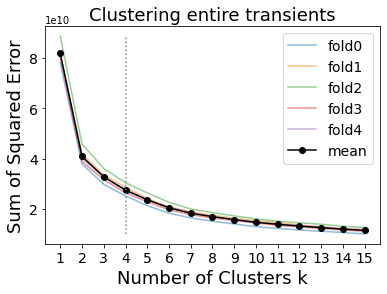

In [6]:
# compute elbow plots
inertias = []
ks = []
for k in range(1,16):
    ks.append(k)
    currentInertias = []
    for foldNumber in range(noOfFolds):
        trainset = db_train[db_train["foldNo"] != foldNumber].copy()
        dataElbow = pd.DataFrame(data = np.vstack(trainset["LP725"].to_numpy()))
        kmeans = KMeans(n_clusters = k, random_state = 0)
        cluster_found = kmeans.fit_predict(dataElbow)
        currentInertias.append(kmeans.inertia_)     
    inertias.append(currentInertias)

for x in range(5):
    plt.plot(ks, np.asarray(inertias)[:,x], label = "fold"+str(x),alpha = 0.5)   
    
meanList = []
for x in range(len(np.asarray(inertias))):
    meanList.append(np.mean(np.asarray(inertias)[x,:]))

plt.plot(ks,meanList,"k-o", label = "mean") 
plt.xlabel('Number of Clusters k', fontsize = fontSizeSetLarge)
plt.ylabel('Sum of Squared Error', fontsize = fontSizeSetLarge)
plt.xticks(ks)
plt.tick_params(axis = 'both', which = 'major', labelsize = fontSizeSetMedium)
plt.vlines(4,ymin = np.min(np.asarray(inertias)),ymax = np.max(np.asarray(inertias)),color = "grey",linestyles = "dotted")
plt.legend(fontsize = fontSizeSetMedium)
plt.title("Clustering entire transients",fontsize = fontSizeSetLarge)
fig.tight_layout()
plt.show()

# Evalution of the model with k=4

In [7]:
# choose k for testing
k_test = 4

In [8]:
# cross validation with k=4
maeList_valid_train = [[],[],[],[],[]]

# iterate through all folds
for foldNumber in range(noOfFolds):

    trainset = db_train[db_train["foldNo"] != foldNumber].copy()
    validset = db_train[db_train["foldNo"] == foldNumber].copy()

    # generate clusters on training data
    currentTrainData = pd.DataFrame(data = np.vstack(trainset["LP725"].to_numpy()))
    X = currentTrainData.values.copy()
    kmeans = KMeans(n_clusters = k_test, random_state = 0)
    cluster_found = kmeans.fit_predict(X)
    currentTrainCluster = currentTrainData.set_index(pd.Series(cluster_found, name = 'cluster'), append = True )
    clusters = sorted(currentTrainCluster.index.get_level_values('cluster').unique())

    listPCE,listVOC,listJSC,listFF = [],[],[],[]
    for cluster in clusters:
        clusterDF = currentTrainCluster.xs(cluster, level = 1)
        listPCE.append(trainset.iloc[clusterDF.index]["pce_backward"])
        listVOC.append(trainset.iloc[clusterDF.index]["voc_backward"])
        listJSC.append(trainset.iloc[clusterDF.index]["jsc_backward"])
        listFF.append(trainset.iloc[clusterDF.index]["ff_backward"])
    pvParams = [listPCE,listVOC,listJSC,listFF]

    cluster_means = []
    for j in range(4):
        currentParam = []
        for i in range(k_test):
            currentParam.append(pvParams[j][i].mean())
        cluster_means.append(currentParam)

    # assign validation data to the generated clusters
    currentValidData = pd.DataFrame(data = np.vstack(validset["LP725"].to_numpy()))
    X2 = currentValidData.values.copy()
    cluster_found2 = kmeans.predict(X2)
    cluster_found_sr2 = pd.Series(cluster_found2, name = 'cluster')
    currentValidCluster = currentValidData.set_index(cluster_found_sr2, append = True )
    clusters2 = sorted(currentValidCluster.index.get_level_values('cluster').unique())

    listPCE_valid,listVOC_valid,listJSC_valid,listFF_valid = [],[],[],[]
    for cluster in clusters2:
        clusterDF2 = currentValidCluster.xs(cluster, level = 1)
        listPCE_valid.append(validset.iloc[clusterDF2.index]["pce_backward"])
        listVOC_valid.append(validset.iloc[clusterDF2.index]["voc_backward"])
        listJSC_valid.append(validset.iloc[clusterDF2.index]["jsc_backward"])
        listFF_valid.append(validset.iloc[clusterDF2.index]["ff_backward"])
    pvParams_valid = [listPCE_valid,listVOC_valid,listJSC_valid,listFF_valid]


    # compute mae on validation data
    sumMAEClustersList_valid_train = []
    for j in range(4):
        currentParam = []
        for ix,ab in enumerate(clusters2):
            currentMeanTrain = cluster_means[j][ab]
            currentCluster = pvParams_valid[j][ix]
            sumMAE = 0
            for ac in range(len(currentCluster)):
                sumMAE += np.abs(np.array(currentCluster)[ac]-currentMeanTrain)
            currentParam.append(sumMAE/(ac+1))
        sumMAEClustersList_valid_train.append(currentParam)
    mae_valid_train = [] 
    for j in range(4):
        mae_valid_train.append(np.round(sum(sumMAEClustersList_valid_train[j])/len(sumMAEClustersList_valid_train[j]),3))     # MAE mean taken from 4 clusters of current fold
    maeList_valid_train[foldNumber].append(mae_valid_train) 

meanMAEAllParams = [np.round(np.mean(np.array(maeList_valid_train)[:,0,0]),3),
                   np.round(np.mean(np.array(maeList_valid_train)[:,0,1]),3),
                   np.round(np.mean(np.array(maeList_valid_train)[:,0,2]),3),
                   np.round(np.mean(np.array(maeList_valid_train)[:,0,3]),3)]

print("k_test: ",k_test)
print("-"*100)
print("cross validation using train and validation set") 
for j in range(5):
    print("fold",j,": mae (pce,voc,jsc,ff) ", maeList_valid_train[j][0])
print("-"*100)
print("baseline mae (pce,voc,jsc,ff)            ",baselineValidation)
print("mae on validation set (pce,voc,jsc,ff)   ",meanMAEAllParams)

k_test:  4
----------------------------------------------------------------------------------------------------
cross validation using train and validation set
fold 0 : mae (pce,voc,jsc,ff)  [1.814, 0.038, 0.986, 6.398]
fold 1 : mae (pce,voc,jsc,ff)  [1.286, 0.016, 1.148, 3.893]
fold 2 : mae (pce,voc,jsc,ff)  [1.391, 0.026, 1.136, 4.516]
fold 3 : mae (pce,voc,jsc,ff)  [1.777, 0.037, 1.43, 5.693]
fold 4 : mae (pce,voc,jsc,ff)  [1.66, 0.027, 1.425, 4.809]
----------------------------------------------------------------------------------------------------
baseline mae (pce,voc,jsc,ff)             [1.888, 0.03, 1.353, 6.413]
mae on validation set (pce,voc,jsc,ff)    [1.586, 0.029, 1.225, 5.062]


# Testing

In [9]:
# Testing
# get train data to train the model on the entire training set 
trainset = db_train.copy()
trainData = pd.DataFrame(data = np.vstack(trainset["LP725"].to_numpy()))
X = trainData.values.copy() 

# generate the kmeans model 
kmeans = KMeans(n_clusters = k_test, random_state = 0)
cluster_found = kmeans.fit_predict(X)
trainData = trainData.set_index(pd.Series(cluster_found, name = 'cluster'), append = True )
clusters = sorted(trainData.index.get_level_values('cluster').unique())

# generate a nested list with the PV parameters (pce,voc,jsc,ff) for the generated clusters in the training data
listPCE,listVOC,listJSC,listFF = [],[],[],[]
for cluster in clusters:
    clusterDF = trainData.xs(cluster, level = 1)
    listPCE.append(trainset.iloc[clusterDF.index]["pce_backward"])
    listVOC.append(trainset.iloc[clusterDF.index]["voc_backward"])
    listJSC.append(trainset.iloc[clusterDF.index]["jsc_backward"])
    listFF.append(trainset.iloc[clusterDF.index]["ff_backward"])
pvParams = [listPCE,listVOC,listJSC,listFF]

# compute mean of each PV parameter for each cluster in the training data
cluster_means = []
for j in range(4):
    currentParam = []
    for i in range(k_test):
        currentParam.append(pvParams[j][i].mean())
    cluster_means.append(currentParam)


# get test data to test the model on unseen data
testData = pd.DataFrame(data = np.vstack(db_test["LP725"].to_numpy()))
X3 = testData.values.copy()
cluster_found3 = kmeans.predict(X3)
testData = testData.set_index(pd.Series(cluster_found3, name = 'cluster'), append = True )
clusters3 = sorted(testData.index.get_level_values('cluster').unique())

# generate a nested list with the PV parameters (pce,voc,jsc,ff) for the generated clusters in the test data
listPCE_test,listVOC_test,listJSC_test,listFF_test = [],[],[],[]
for cluster in clusters3: 
    clusterDF3 = testData.xs(cluster, level = 1)
    listPCE_test.append(db_test.iloc[clusterDF3.index]["pce_backward"])
    listVOC_test.append(db_test.iloc[clusterDF3.index]["voc_backward"])
    listJSC_test.append(db_test.iloc[clusterDF3.index]["jsc_backward"])
    listFF_test.append(db_test.iloc[clusterDF3.index]["ff_backward"])
pvParams_test = [listPCE_test,listVOC_test,listJSC_test,listFF_test]

# compute the mae using the nested list of the training data and the nested list of test data
sumMAEClustersList_test_train = []
for j in range(4):
    currentParam = []
    for ix,ab in enumerate(clusters3):
        currentMeanTest = cluster_means[j][ab]
        currentCluster = pvParams_test[j][ix]
        sumMAE = 0
        for ac in range(len(currentCluster)):
            sumMAE += np.abs(np.array(currentCluster)[ac]-currentMeanTest)

        currentParam.append(sumMAE/(ac+1))
    sumMAEClustersList_test_train.append(currentParam)

mae_test_train = []
for j in range(4):
    mae_test_train.append(np.round(sum(sumMAEClustersList_test_train[j])/len(sumMAEClustersList_test_train[j]),3))
print("k_test: ",k_test)
print("-"*100)
print("test set: compute MAE when compared to cluster generated on entire train set")
print("baseline mae (pce,voc,jsc,ff)      ",baselineTestSet)
print("mae on test set (pce,voc,jsc,ff)   ",mae_test_train)

k_test:  4
----------------------------------------------------------------------------------------------------
test set: compute MAE when compared to cluster generated on entire train set
baseline mae (pce,voc,jsc,ff)       [1.909, 0.034, 1.293, 6.412]
mae on test set (pce,voc,jsc,ff)    [1.671, 0.033, 1.216, 5.443]
